In [2]:
import math
import collections
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Tuning & Splitting Libraries
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Loading Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation Liabraries
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score


In [4]:
jet_data= pd.read_csv('train_FD001.txt', sep=" ", header=None)

In [5]:
jet_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21","sensor22","sensor23"]

jet_data.drop(['sensor22', 'sensor23'], axis=1, inplace=True)

jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()
jet_id_and_rul.set_index('id', inplace=True)

In [6]:
def RUL_calculator(df, df_max_cycles):
    max_cycle = df_max_cycles["cycle"]
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='id', right_index=True)
    result_frame["RUL"] = result_frame["max_cycle"] - result_frame["cycle"] 
    result_frame.drop(['max_cycle'], axis=1, inplace=True)
    return result_frame

jet_data = RUL_calculator(jet_data, jet_id_and_rul)

In [7]:
jet_data.head()


id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
0   1      1 -0.0007 -0.0004  100.0   518.67   641.82  1589.70  1400.60   
1   1      2  0.0019 -0.0003  100.0   518.67   642.15  1591.82  1403.14   
2   1      3 -0.0043  0.0003  100.0   518.67   642.35  1587.99  1404.20   
3   1      4  0.0007  0.0000  100.0   518.67   642.35  1582.79  1401.87   
4   1      5 -0.0019 -0.0002  100.0   518.67   642.37  1582.85  1406.22   

   sensor5  ...  sensor13  sensor14  sensor15  sensor16  sensor17  sensor18  \
0    14.62  ...   2388.02   8138.62    8.4195      0.03       392      2388   
1    14.62  ...   2388.07   8131.49    8.4318      0.03       392      2388   
2    14.62  ...   2388.03   8133.23    8.4178      0.03       390      2388   
3    14.62  ...   2388.08   8133.83    8.3682      0.03       392      2388   
4    14.62  ...   2388.04   8133.80    8.4294      0.03       393      2388   

   sensor19  sensor20  sensor21  RUL  
0     100.0     39.06   23.4190  191  
1     100.0     39.00   23.4236  190  
2     100.0     38.95   23.3442  189  
3     100.0     38.88   23.3739  188  
4     100.0     38.90   23.4044  187  

[5 rows x 27 columns]

In [9]:
jet_data.describe()


id         cycle           op1           op2      op3  \
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.0   
mean      51.506568    108.807862     -0.000009      0.000002    100.0   
std       29.227633     68.880990      0.002187      0.000293      0.0   
min        1.000000      1.000000     -0.008700     -0.000600    100.0   
25%       26.000000     52.000000     -0.001500     -0.000200    100.0   
50%       52.000000    104.000000      0.000000      0.000000    100.0   
75%       77.000000    156.000000      0.001500      0.000300    100.0   
max      100.000000    362.000000      0.008700      0.000600    100.0   

            sensor1       sensor2       sensor3       sensor4       sensor5  \
count  2.063100e+04  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   5.186700e+02    642.680934   1590.523119   1408.933782  1.462000e+01   
std    6.537152e-11      0.500053      6.131150      9.000605  3.394700e-12   
min    5.186700e+02    641.210000   1571.040000   1382.250000  1.462000e+01   
25%    5.186700e+02    642.325000   1586.260000   1402.360000  1.462000e+01   
50%    5.186700e+02    642.640000   1590.100000   1408.040000  1.462000e+01   
75%    5.186700e+02    643.000000   1594.380000   1414.555000  1.462000e+01   
max    5.186700e+02    644.530000   1616.910000   1441.490000  1.462000e+01   

       ...      sensor13      sensor14      sensor15      sensor16  \
count  ...  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   ...   2388.096152   8143.752722      8.442146  3.000000e-02   
std    ...      0.071919     19.076176      0.037505  1.556432e-14   
min    ...   2387.880000   8099.940000      8.324900  3.000000e-02   
25%    ...   2388.040000   8133.245000      8.414900  3.000000e-02   
50%    ...   2388.090000   8140.540000      8.438900  3.000000e-02   
75%    ...   2388.140000   8148.310000      8.465600  3.000000e-02   
max    ...   2388.560000   8293.720000      8.584800  3.000000e-02   

           sensor17  sensor18  sensor19      sensor20      sensor21  \
count  20631.000000   20631.0   20631.0  20631.000000  20631.000000   
mean     393.210654    2388.0     100.0     38.816271     23.289705   
std        1.548763       0.0       0.0      0.180746      0.108251   
min      388.000000    2388.0     100.0     38.140000     22.894200   
25%      392.000000    2388.0     100.0     38.700000     23.221800   
50%      393.000000    2388.0     100.0     38.830000     23.297900   
75%      394.000000    2388.0     100.0     38.950000     23.366800   
max      400.000000    2388.0     100.0     39.430000     23.618400   

                RUL  
count  20631.000000  
mean     107.807862  
std       68.880990  
min        0.000000  
25%       51.000000  
50%      103.000000  
75%      155.000000  
max      361.000000  

[8 rows x 27 columns]

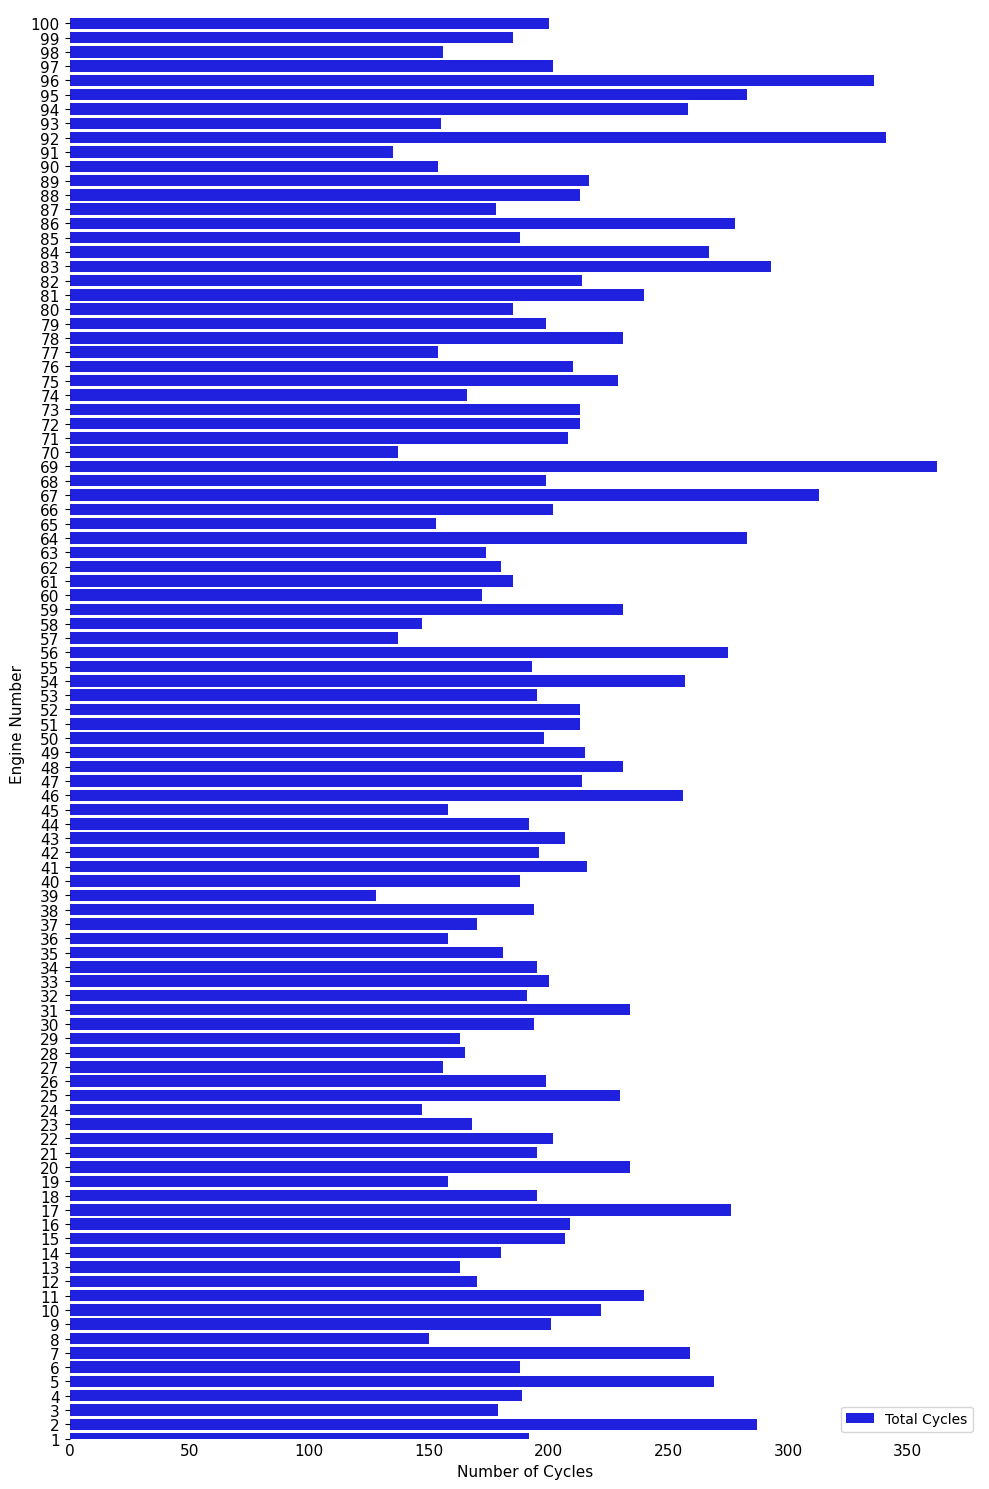

In [10]:
jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="cycle", y="id", data=jet_id_and_rul, label="Total Cycles", color="blue", orient = 'h', dodge=False)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0, 100), ylabel="",xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)
ax.tick_params(labelsize=11)
ax.tick_params(length=0, axis='x')
ax.set_ylabel("Engine Number", fontsize=11)
ax.set_xlabel("Number of Cycles", fontsize=11)
plt.tight_layout()
plt.show()

Mean number of cycles after which jet engine fails is 206


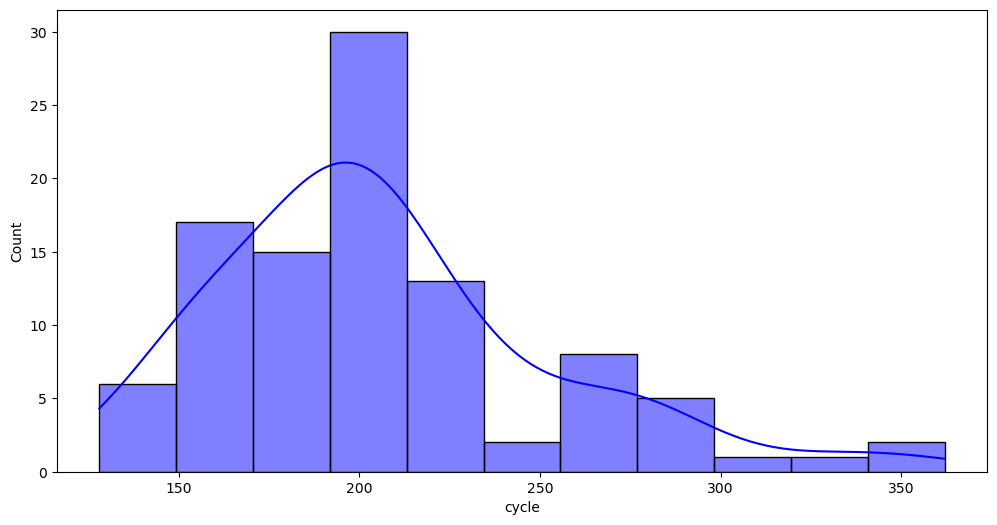

In [11]:
plt.subplots(figsize=(12, 6))
sns.histplot(jet_id_and_rul["cycle"], kde = True, color='blue');
print("Mean number of cycles after which jet engine fails is "+ str(math.floor(jet_id_and_rul["cycle"].mean())))

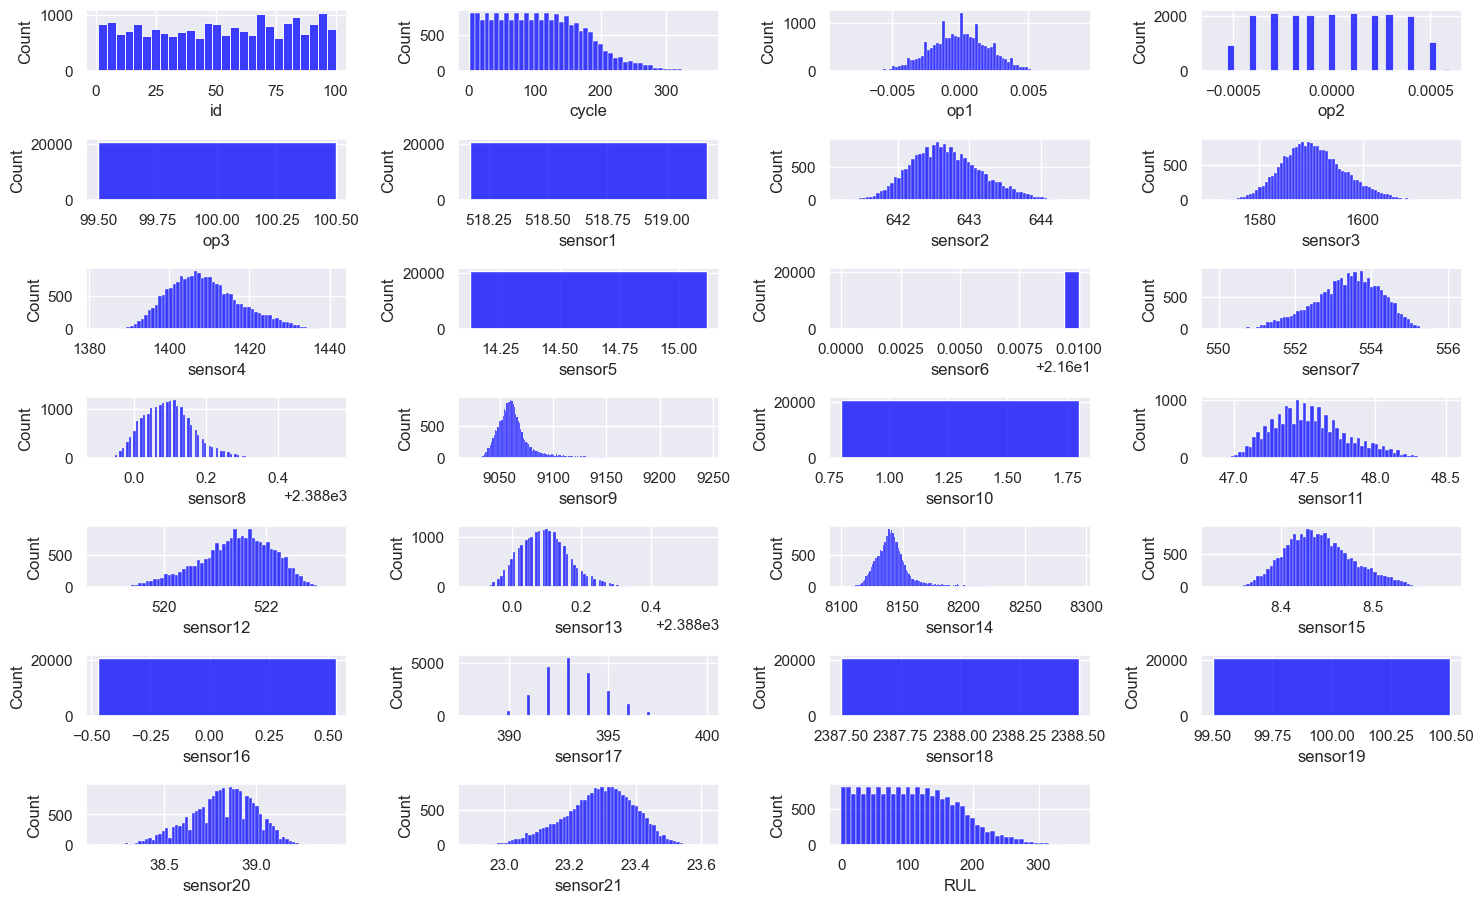

In [12]:
sns.set()
fig = plt.figure(figsize = [15,10])
cols = jet_data.columns
cnt = 1
for col in cols :
    plt.subplot(8,4,cnt)
    sns.histplot(jet_data[col],color='blue')
    cnt+=1
plt.tight_layout()
plt.show() 

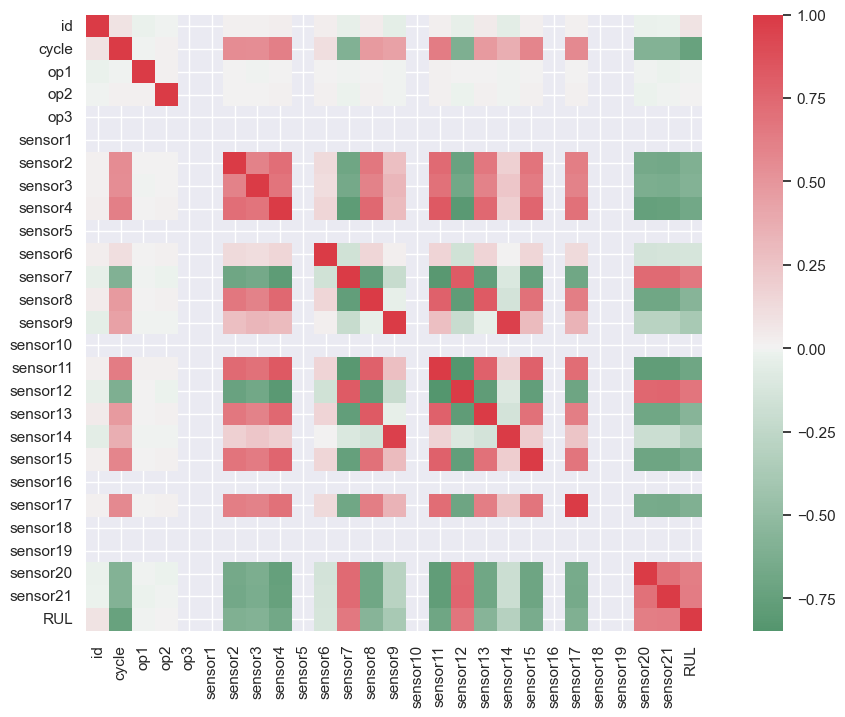

In [13]:
plt.figure(figsize=(13,8))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_data.corr(), cmap =cmap, center=0, annot=False, square=True);

In [14]:
jet_relevant_data = jet_data.drop(["cycle", "op1", "op2", "op3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19", "sensor14", "sensor13", "sensor12", "sensor11"], axis=1)

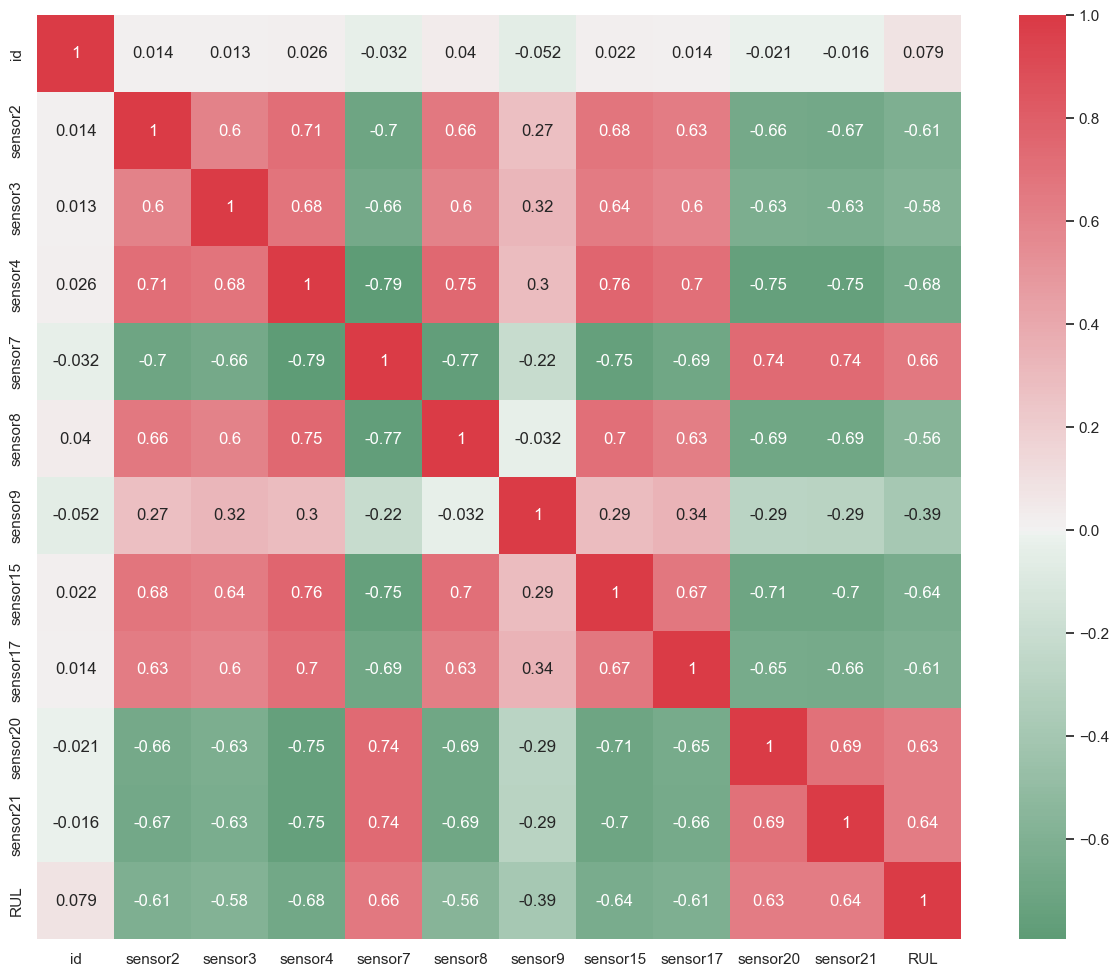

In [15]:
plt.figure(figsize=(15, 12))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_relevant_data.corr(), cmap =cmap, center=0, annot=True, square=True);

In [16]:
def plot_sensor(sensor_name,X):
    plt.figure(figsize=(13,5))
    for i in X['id'].unique():
        if (i % 10 == 0):  # only plot every engine
            plt.plot('RUL', sensor_name, 
                     data=X[X['id']==i].rolling(8).mean())
            plt.axvline(30, color='red', linestyle='dashed', linewidth=2)
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

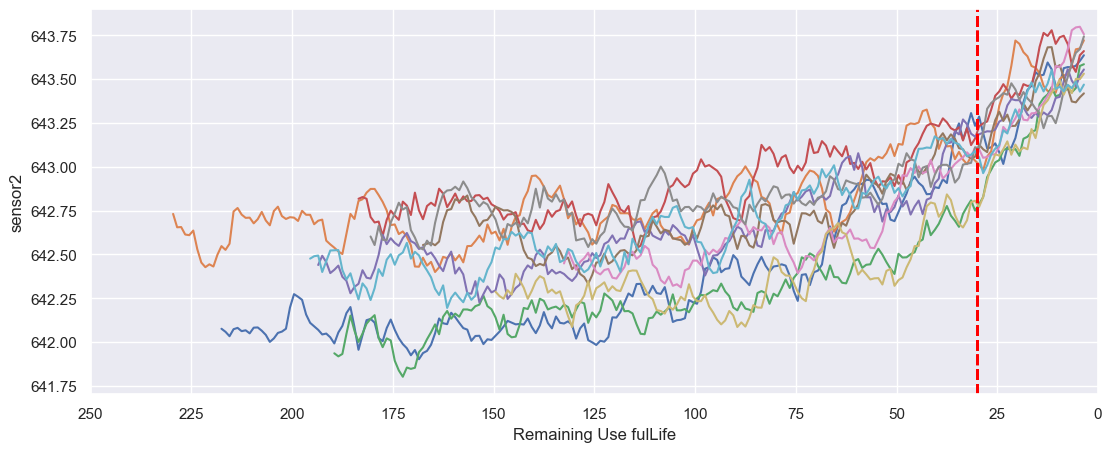

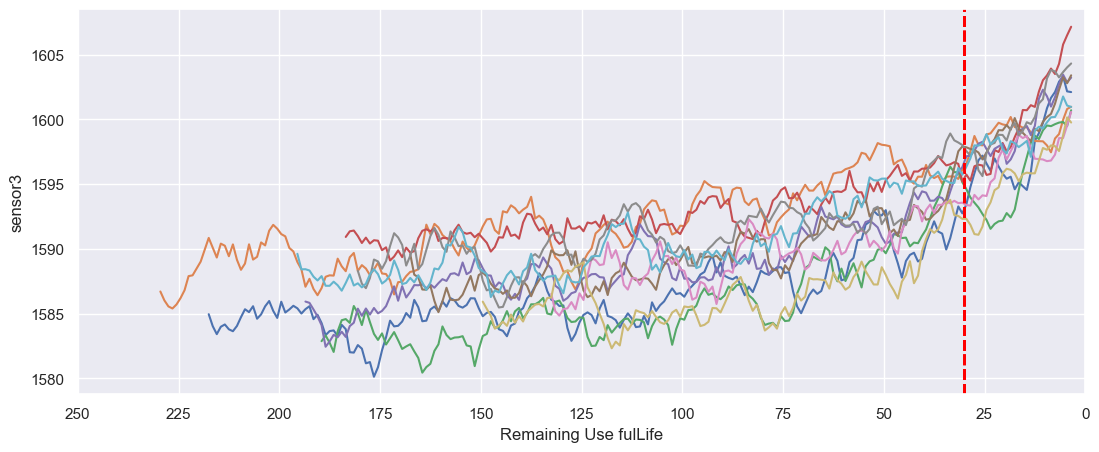

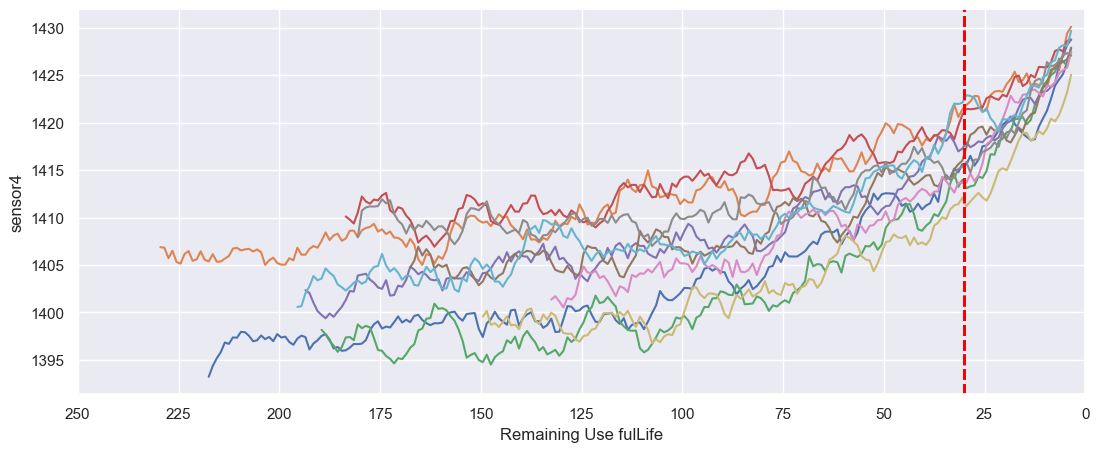

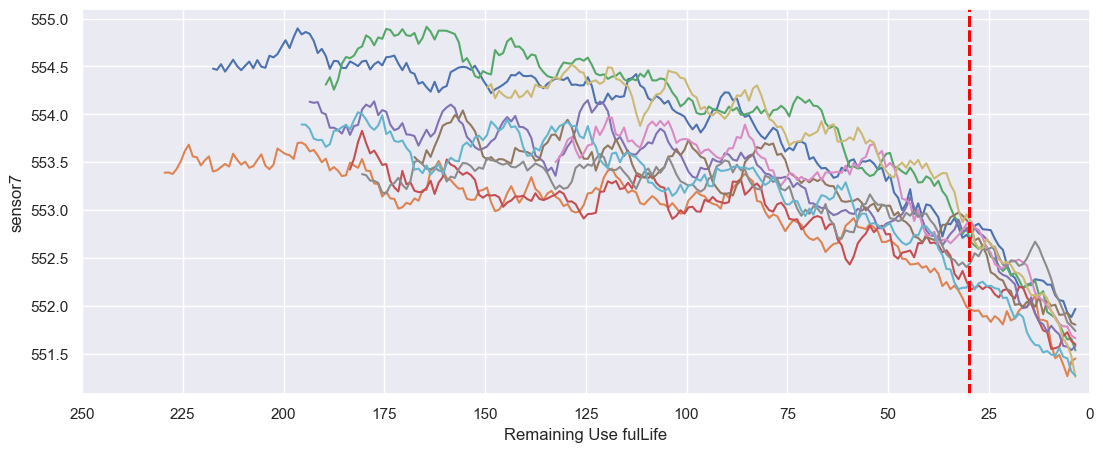

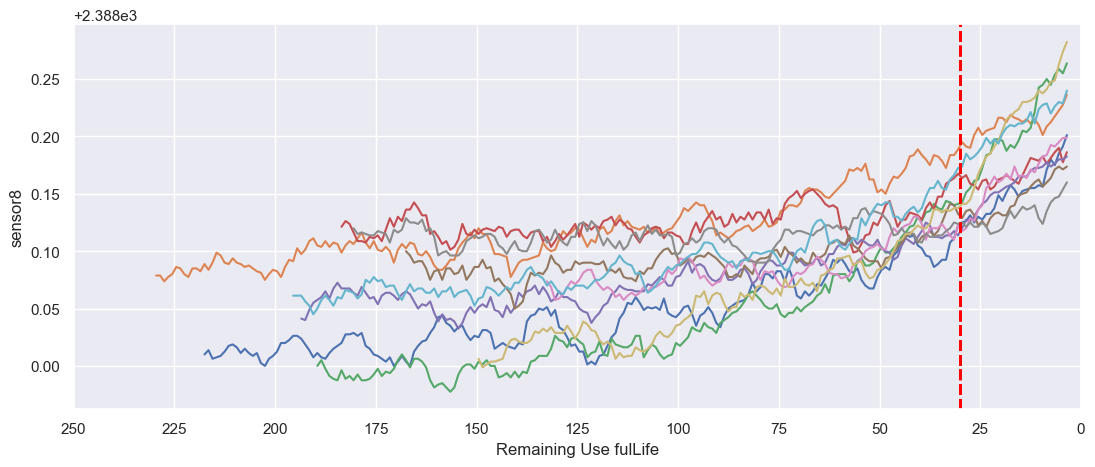

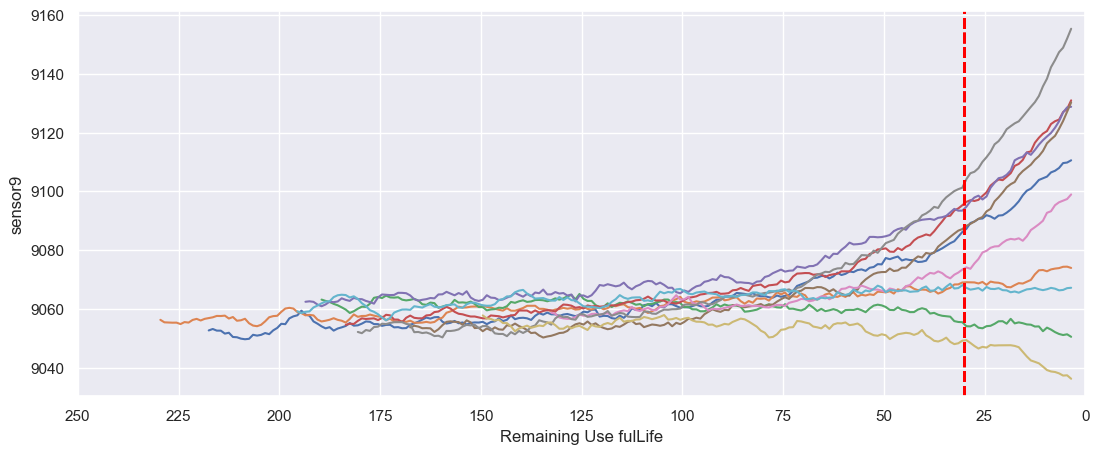

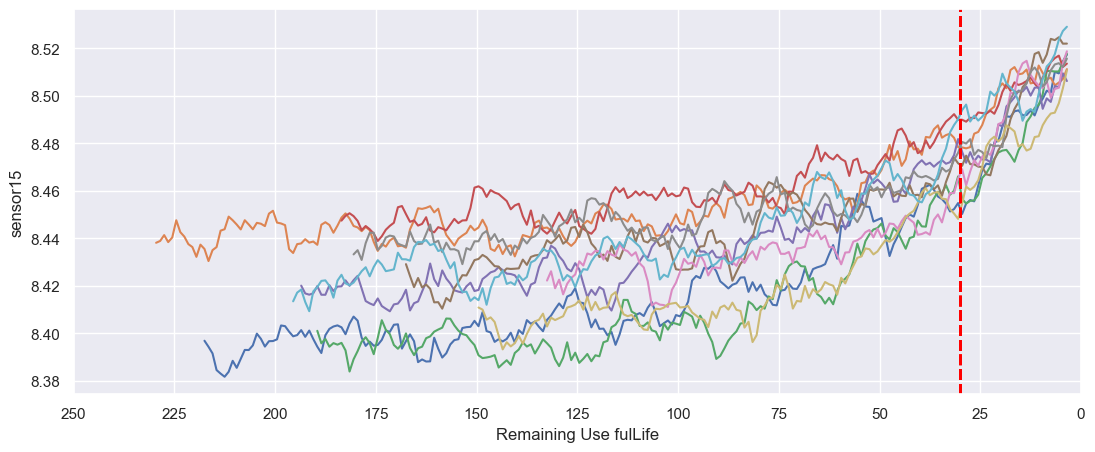

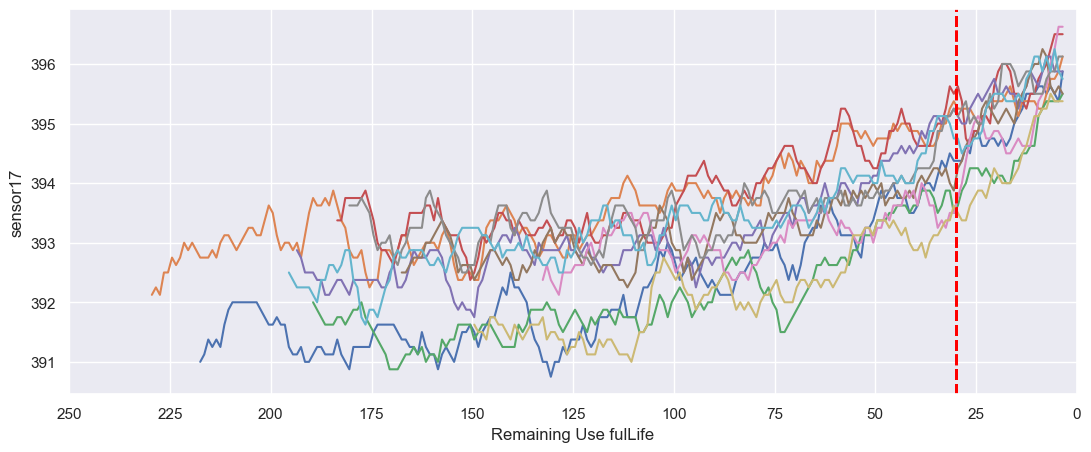

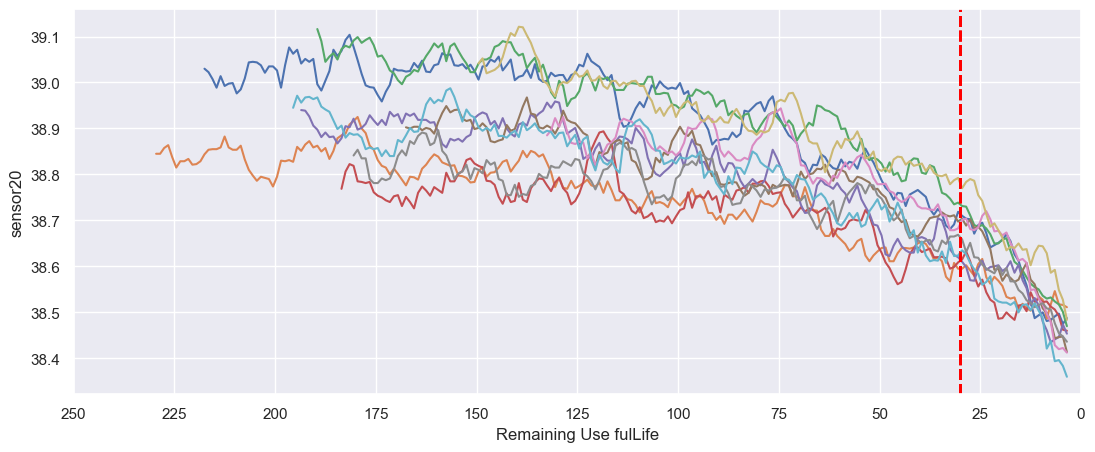

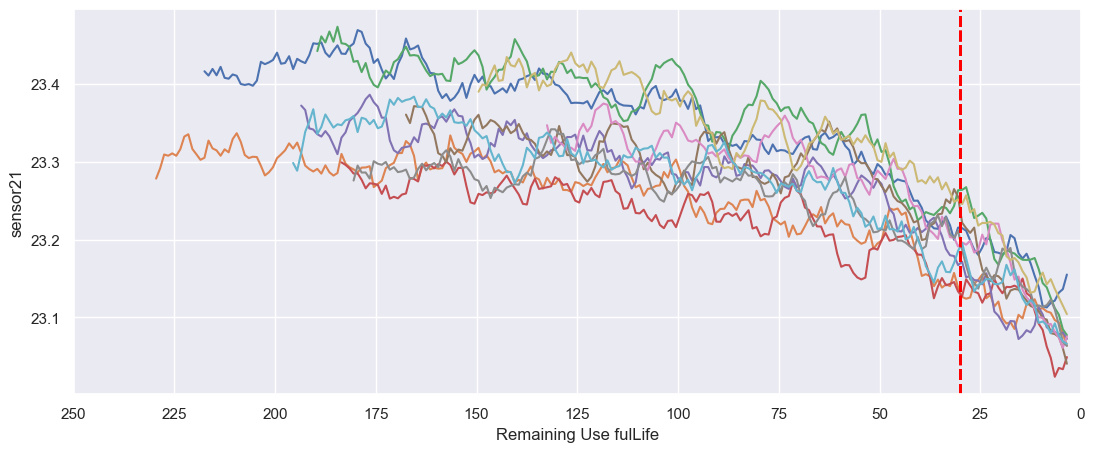

In [17]:
for sensor in jet_relevant_data.drop(['id', 'RUL'], axis=1).columns:
    plot_sensor(sensor, jet_relevant_data)


In [18]:
jet_relevant_data.drop('sensor9', axis=1, inplace=True)

In [19]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(jet_relevant_data.drop(['id', 'RUL'], axis=1))
scaled_features = pd.DataFrame(scaled_features, columns=jet_relevant_data.drop(['id', 'RUL'], axis=1).columns)

In [20]:
scaled_features['id'] = jet_relevant_data['id']
scaled_features['RUL'] = jet_relevant_data['RUL']

In [21]:
scaled_features.head()

sensor2   sensor3   sensor4   sensor7   sensor8  sensor15  sensor17  \
0  0.183735  0.406802  0.309757  0.726248  0.242424  0.363986  0.333333   
1  0.283133  0.453019  0.352633  0.628019  0.212121  0.411312  0.333333   
2  0.343373  0.369523  0.370527  0.710145  0.272727  0.357445  0.166667   
3  0.343373  0.256159  0.331195  0.740741  0.318182  0.166603  0.333333   
4  0.349398  0.257467  0.404625  0.668277  0.242424  0.402078  0.416667   

   sensor20  sensor21  id  RUL  
0  0.713178  0.724662   1  191  
1  0.666667  0.731014   1  190  
2  0.627907  0.621375   1  189  
3  0.573643  0.662386   1  188  
4  0.589147  0.704502   1  187

In [22]:
data = scaled_features.copy()

In [23]:
cycle=30
data['label'] = data['RUL'].apply(lambda x: 1 if x <= cycle else 0)

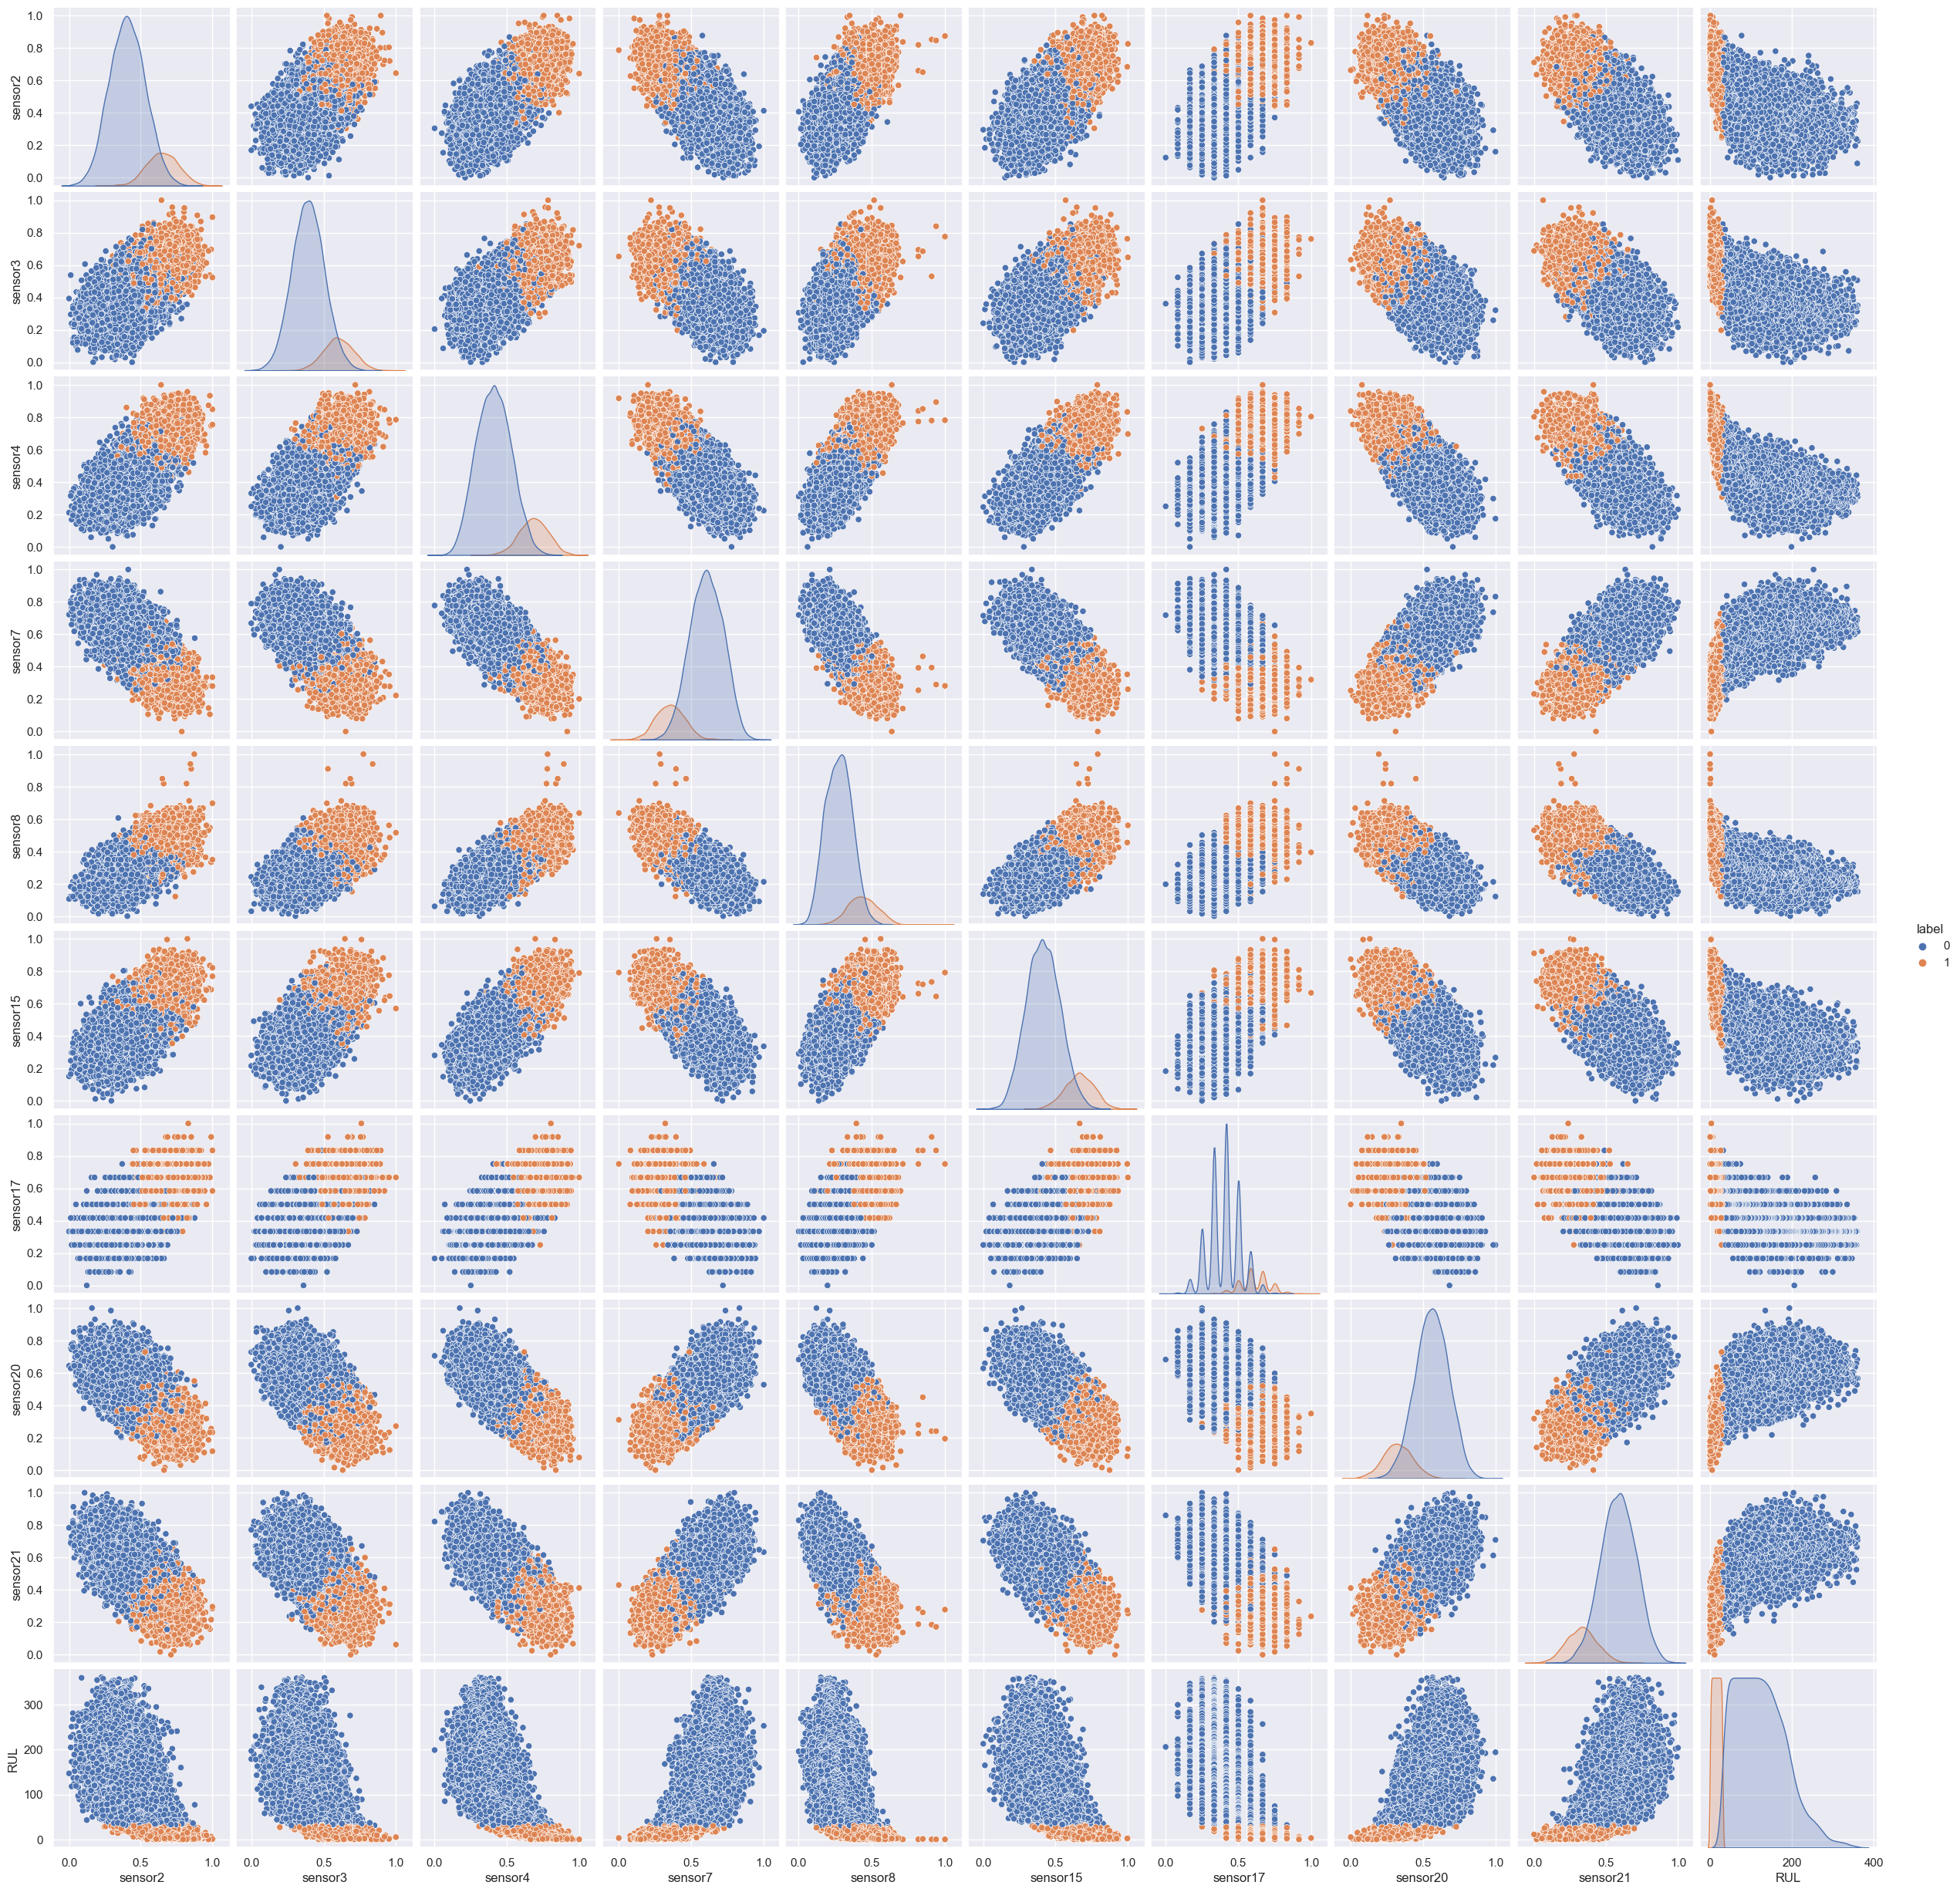

In [24]:
sns.pairplot(data.drop(['id'], axis=1), hue="label")

In [25]:
y = data['label']
X = data.drop(['RUL', 'id', 'label'], axis=1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)

print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (16504, 9)
X_test shape :  (4127, 9)
y_train shape :  (16504,)
y_test shape :  (4127,)


# Model Building


In [27]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [28]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 95.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 94.0 % accuracy score
Classifiers:  SVC Has a training score of 95.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 92.0 % accuracy score


In [29]:
classifiers = []

log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

log_reg = grid_log_reg.best_estimator_
classifiers.append(log_reg)

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

knears_neighbors = grid_knears.best_estimator_
classifiers.append(knears_neighbors)

svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

svc = grid_svc.best_estimator_
classifiers.append(svc)

tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

tree_clf = grid_tree.best_estimator_
classifiers.append(tree_clf)

In [30]:
for classifier in classifiers:
    model_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(str(classifier.__class__.__name__) +' Cross Validation Score: ', round(model_score.mean() * 100, 2).astype(str) + '%')

LogisticRegression Cross Validation Score:  94.94%
KNeighborsClassifier Cross Validation Score:  94.1%
SVC Cross Validation Score:  94.98%
DecisionTreeClassifier Cross Validation Score:  93.66%


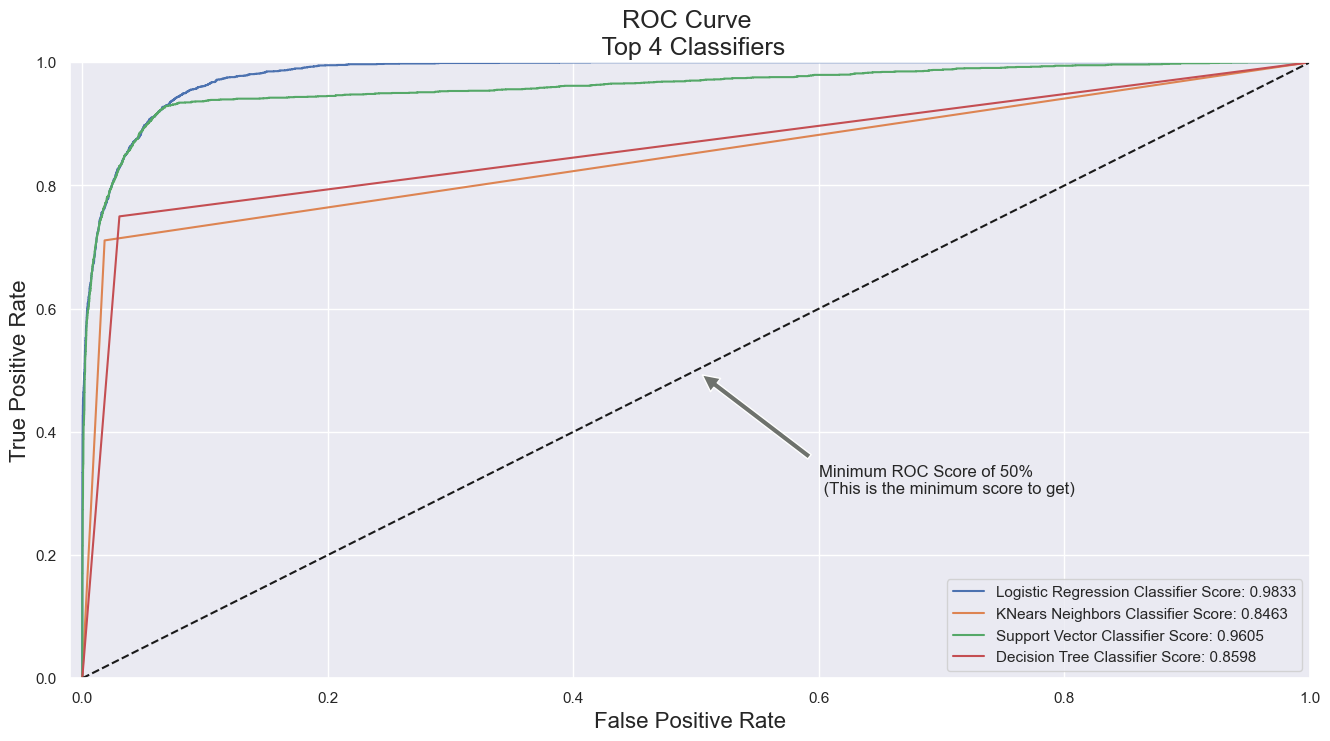

In [31]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")
knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")
tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

In [32]:
for classifier in classifiers:
    pred = classifier.predict(X_test)
    print(str(classifier) + ' Acc Score: ',accuracy_score(y_test, pred))
    print(str(classifier) + ' Roc Auc Score: ',roc_auc_score(y_test, pred))
    print(str(classifier) + ' Precision Score: ',precision_score(y_test, pred))
    print(str(classifier) + ' Recall Score: ',recall_score(y_test, pred))
    print(str(classifier) + ' f1 score: ',f1_score(y_test, pred))
    print("======================================================")

LogisticRegression(C=1) Acc Score:  0.9471771262418222
LogisticRegression(C=1) Roc Auc Score:  0.8809398965777183
LogisticRegression(C=1) Precision Score:  0.8473684210526315
LogisticRegression(C=1) Recall Score:  0.7866449511400652
LogisticRegression(C=1) f1 score:  0.8158783783783785
KNeighborsClassifier(n_neighbors=4) Acc Score:  0.9411194572328568
KNeighborsClassifier(n_neighbors=4) Roc Auc Score:  0.8498295303345137
KNeighborsClassifier(n_neighbors=4) Precision Score:  0.8615984405458089
KNeighborsClassifier(n_neighbors=4) Recall Score:  0.7198697068403909
KNeighborsClassifier(n_neighbors=4) f1 score:  0.7843833185448091
SVC(C=0.7) Acc Score:  0.9469348194814635
SVC(C=0.7) Roc Auc Score:  0.8700455080292743
SVC(C=0.7) Precision Score:  0.8664192949907236
SVC(C=0.7) Recall Score:  0.760586319218241
SVC(C=0.7) f1 score:  0.8100607111882047
DecisionTreeClassifier(max_depth=3, min_samples_leaf=5) Acc Score:  0.9319118003392295
DecisionTreeClassifier(max_depth=3, min_samples_leaf=5) Ro

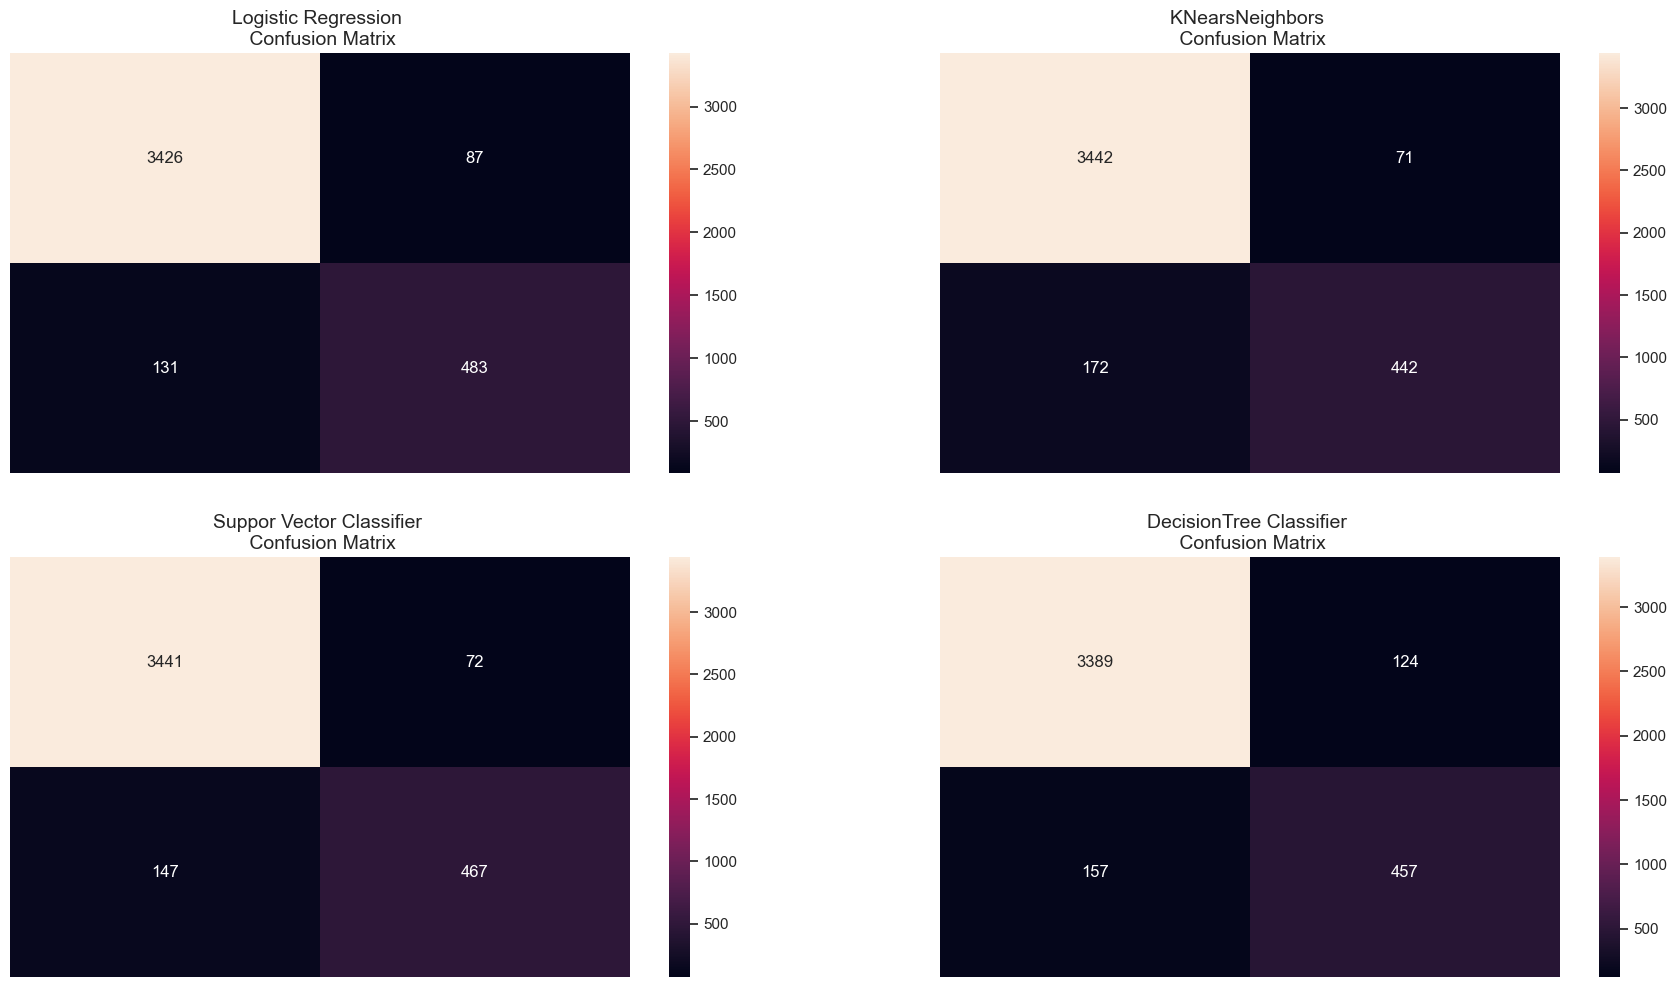

In [33]:
y_pred_log_reg = log_reg.predict(X_test)
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))

sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap='rocket', fmt='g')
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap='rocket', fmt='g')
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap='rocket', fmt='g')
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap='rocket', fmt='g')
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()